# SQL勉強会

***徹底的にSQLが集合操作であることを理解する会***

## 目的
- SELECT * FROM tbl_name;を脱出する
  - SQLの考え方の基本をご理解頂く
  - なんとなく、SQL次の一歩の背中を押す
  
## やること
- 特にSELECT文の書き方のコツ

## やらないこと
- SQLの文法そのものの話
- Databaseのアーキテクチャの話

## アジェンダ
- SQL考え方
- 実際に集計してみる
  - カラムでしぼってみる
  - GROUP BYで合計値の集計をしてみる
  - (少し寄り道)グラフ化してみる
  - 時系列処理をしてみる -> グラフ化
  
## おことわり 

ここで実施する集計そのものはほぼ意味はありません。
意味があるデータを入手できていないためなのでご容赦ください。

## SQLの考え方
SQLは集合に対する操作と考えられる

### 用意したデータについて
- Apacheアクセスログをダミーで生成し、テーブルにいれました

### 接続
- 以下User/PasswordでオフィスWifiからのみ接続可能

```bash
mysql -u sample_user -p -h rm-e9b97zksl36631w9txo.mysql.japan.rds.aliyuncs.com
```

### まずはSELECTしてみる
とはいえ全件やると大変なので、limitで絞る

***クエリ***
```SQL
SELECT * FROM access_log LIMIT 3;
```

***出力***
```bash
+-----------------+------------------+---------------------+--------------------+------------------------------+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------+--------+
| remote_host     | request_http_ver | request_method      | request_url        | time_recieved                | user_agent                                                                                                                      | referer                        | status |
+-----------------+------------------+---------------------+--------------------+------------------------------+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------+--------+
| 124.225.130.224 | 1.1              | data.request_method | /item/software/977 | [04/Mar/2019:07:01:40 +0000] | Mozilla/5.0 (iPad; CPU OS 5_0_1 like Mac OS X) AppleWebKit/534.46 (KHTML, like Gecko) Version/5.1 Mobile/9A405 Safari/7534.48.3 | /search/?c=Jewelry+Electronics | 200    |
| 152.129.208.217 | 1.1              | data.request_method | /item/games/917    | [04/Mar/2019:07:01:40 +0000] | Mozilla/5.0 (Windows NT 6.1; WOW64; rv:10.0.1) Gecko/20100101 Firefox/10.0.1                                                    | /search/?c=Games+Software      | 200    |
| 152.225.99.208  | 1.1              | data.request_method | /item/books/795    | [04/Mar/2019:07:01:41 +0000] | Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.56 Safari/535.11                     | /category/electronics          | 404    |
+-----------------+------------------+---------------------+--------------------+------------------------------+---------------------------------------------------------------------------------------------------------------------------------+--------------------------------+--------+
```

日本語でいうと、access_logテーブルの全カラムを対象に先頭3件からなる***集合を作った***といえる。
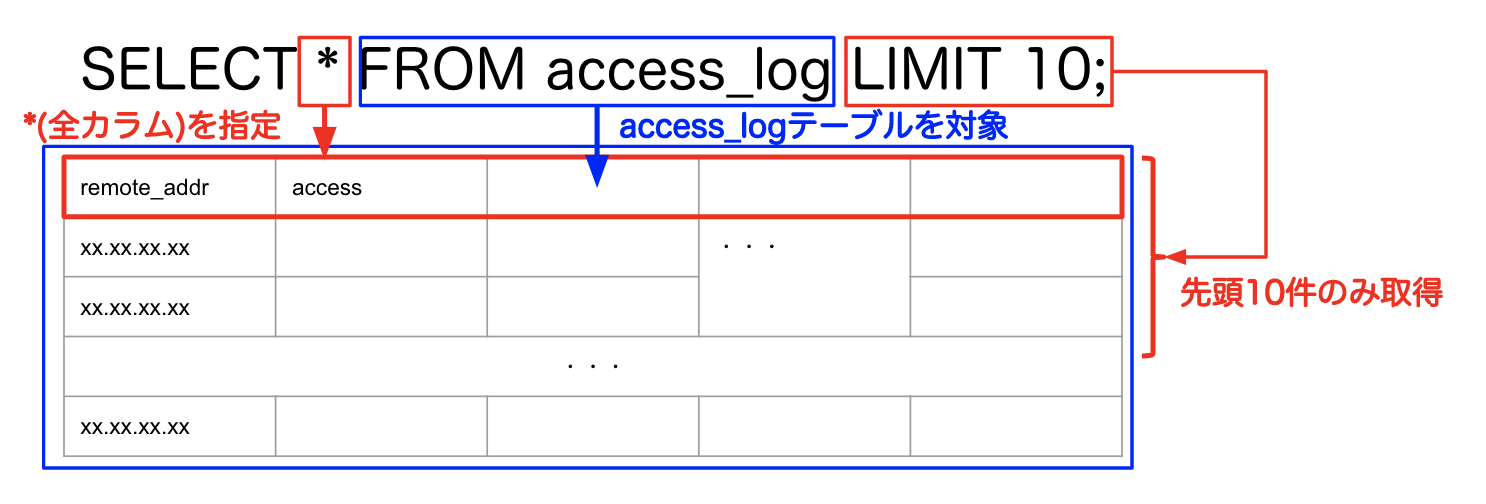

## 集計する
### まずはカラムでしぼってみる

アクセス元IPアドレスのみ表示したい場合

例のごとく全部出すと大変なので最初10件のみ表示させる

***クエリ***
```SQL
SELECT remote_host FROM access_log LIMIT 3;
```

***出力***
```bash
+-----------------+
| remote_host     |
+-----------------+
| 124.225.130.224 |
| 152.129.208.217 |
| 152.225.99.208  |
+-----------------+
3 rows in set (0.01 sec)
```

### COUNTを使ってみる
- COUNTは特定の行内のNULLでないセルの個数を集約して返します。
- 以下の場合はremote_hostは全てNULLではないので、そのまま10800が返ります。
- また、COUNTのような関数を利用した場合、そこにAS句を使って名前をつけることができます。 

***クエリ***

```SQL
SELECT COUNT(remote_host) AS count FROM access_log;
```

***出力***
```bash
+-------+
| count |
+-------+
| 10800 |
+-------+
```

### グループ化してみる
- GROUP BY句を使うことで、特定のカラムごとにグループ化し、グループごとの集計が可能です。
- 例えば以下の例ではremote_hostでグループ化し、そのグループごとにCOUNTを取ります。
- COUNTは中は基本的にカラム名ですが、1と書くことで必ずNULLにならずそのグループごとの数えあげが行なえます。

***クエリ***

```SQL
SELECT remote_host, COUNT(1) AS count FROM access_log GROUP BY remote_host ORDER BY count DESC LIMIT 3
```

***出力***
```bash
+-----------------+-------+
| remote_host     | count |
+-----------------+-------+
| 80.45.219.148   |    19 |
| 216.222.35.103  |    19 |
| 128.189.113.151 |    19 |
+-----------------+-------+
3 rows in set (0.12 sec)
```

### 日付を変換する
- 今回の場合、例えばアクセス日時はApacheデフォルトなので、変換しないと利用できません。
- 例えば以下のようにやれます。

***クエリ***

```SQL
SELECT STR_TO_DATE('[04/Mar/2019:07:01:43 +0000]', '[%d/%b/%Y:%k:%i:%S +0000]');
```

***出力***
```bash
+--------------------------------------------------------------------------+
| STR_TO_DATE('[04/Mar/2019:07:01:43 +0000]', '[%d/%b/%Y:%k:%i:%S +0000]') |
+--------------------------------------------------------------------------+
| 2019-03-04 07:01:43                                                      |
+--------------------------------------------------------------------------+
```

どうでもいいですが、上記の通り、実は関数だけでFROMがなくてもSQLって書けます。

### 分ごとのアクセス数を集計してみる
- 今回の場合均一にしているのであまりおもしろくないですが、アクセス数の集計を考えます。

#### まずは時刻を分単位に丸める
- 全部やると18,000件出て大変なので、グループ化+limitも同時にします

***クエリ***
```SQL
SELECT DATE_FORMAT(STR_TO_DATE(time_recieved, '[%d/%b/%Y:%k:%i:%S +0000]'), '%k:%i') AS time FROM access_log GROUP BY time limit 10;
```

***出力***
```SQL
+------+
| time |
+------+
| 7:01 |
| 7:02 |
| 7:03 |
| 7:04 |
| 7:05 |
| 7:06 |
| 7:07 |
| 7:08 |
| 7:09 |
| 7:10 |
+------+
10 rows in set (0.02 sec)
```

#### 分単位でカウントする
- 簡単で単純にCOUNT(1)を追加しただけです。

***クエリ***
```SQL
SELECT DATE_FORMAT(STR_TO_DATE(time_recieved, '[%d/%b/%Y:%k:%i:%S +0000]'), '%k:%i') AS time, COUNT(1) AS count FROM access_log GROUP BY time limit 10;
```

***出力***
```SQL
+------+-------+
| time | count |
+------+-------+
| 7:01 |    59 |
| 7:02 |   179 |
| 7:03 |   180 |
| 7:04 |   180 |
| 7:05 |   179 |
| 7:06 |   180 |
| 7:07 |   180 |
| 7:08 |   180 |
| 7:09 |   179 |
| 7:10 |   180 |
+------+-------+
10 rows in set (0.02 sec)
```

### 欠損のあるデータの集計
- 先程のデータは分単位で欠損のない状態でした。
- 今回のように分単位で集計を取る場合、欠損があると特定時刻が抜けてしまいます。
- 欠損データのあるテーブルとしてaccess_log_with_lossを用意しています。これに対して先程のクエリを実行しましょう。

***クエリ***
```SQL
SELECT DATE_FORMAT(STR_TO_DATE(time_recieved, '[%d/%b/%Y:%k:%i:%S +0000]'), '%k:%i') AS time, COUNT(1) AS count FROM access_log_with_loss GROUP BY time limit 10;
```

***出力***

```SQL
+------+-------+
| time | count |
+------+-------+
| 7:02 |   179 |
| 7:03 |   180 |
| 7:04 |   180 |
| 7:05 |   179 |
| 7:06 |   180 |
| 7:07 |   180 |
| 7:08 |   180 |
| 7:09 |   179 |
| 7:13 |   180 |
| 7:14 |   180 |
+------+-------+
10 rows in set (0.02 sec)
```

- これで問題ないケースもあると思いますが、ないところは０と表示したい場合も多いと思います。
- 例えば、DataVで線グラフ表示しようとすると、このままでは7:09の高さと7:13の高さが直線で結ばれてしまいます。
- こういう場合は欠損のない時刻データの作成とJOINを行うことで解決します。

#### 7:00 - 8:10までの欠損のない時刻テーブルの作成
- まずはベースとなる7:00という文字列を作る

```SQL
SELECT DATE_FORMAT(STR_TO_DATE('2019-03-05 07:00:00', '%Y-%m-%d %k:%i:%S'), '%k:%i') AS base;
```

```bash
+------+
| base |
+------+
| 7:00 |
+------+
1 row in set (0.01 sec)
```

- 次に1~70までの連続値を作りますが、ここではMySQLの方言を使って実現しています。
- 実際にここは使うSQLによって大幅に違うので注意してください。

```SQL
SET @num := 0;
SELECT @num := @num + 1 AS seq FROM information_schema.COLUMNS LIMIT 70;
```

```bash
+------+
| seq  |
+------+
|    1 |
|    2 |
|    3 |
|    4 |
(中略)
|   68 |
|   69 |
|   70 |
+------+
70 rows in set (0.03 sec)
```

- それでは２つを合体させます。

```SQL
SET @num := 0;
SELECT DATE_FORMAT(DATE_ADD(STR_TO_DATE('2019-03-05 07:00:00', '%Y-%m-%d %k:%i:%S'), INTERVAL s.seq MINUTE), '%k:%i') AS base
FROM (
  SELECT @num := @num + 1 AS seq FROM information_schema.COLUMNS LIMIT 70
) s;
```

```bash
+------+
| base |
+------+
| 7:01 |
| 7:02 |
| 7:03 |
(中略　)
| 8:07 |
| 8:08 |
| 8:09 |
| 8:10 |
+------+
```

- これで連続データができました。
- これと元の結果をJOINします。

```SQL
SET @num := 0;
SELECT l.time, r.count 
FROM (
    SELECT DATE_FORMAT(DATE_ADD(STR_TO_DATE('2019-03-05 07:00:00', '%Y-%m-%d %k:%i:%S'), INTERVAL s.seq MINUTE), '%k:%i') AS time
    FROM (
      SELECT @num := @num + 1 AS seq
        FROM information_schema.COLUMNS
        LIMIT 70
    ) s
) l
LEFT OUTER JOIN (
  SELECT DATE_FORMAT(STR_TO_DATE(time_recieved, '[%d/%b/%Y:%k:%i:%S +0000]'), '%k:%i') AS time, COUNT(1) AS count
    FROM access_log_with_loss
    GROUP BY time 
) r
ON l.time = r.time;
```